In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

%matplotlib inline

In [2]:
train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')

## Feature engineering

### Binning Age

In [3]:
def process_age(df):
    df['Age'] = df['Age'].fillna(-0.5)
    cut_points = [-1, 0, 5, 12, 18, 35, 60, 100]
    label_names = ['Missing', 'Infant', 'Child', 'Teenager', 'Young Adult', 'Adult', 'Senior']
    df['Age_Range'] = pd.cut(df['Age'], cut_points, labels=label_names)
    return df

def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

train = process_age(train)
holdout = process_age(holdout)

for feature in ('Age_Range', 'Pclass', 'Sex'):
    train = create_dummies(train, feature)
    holdout = create_dummies(holdout, feature)

### Binning Fare

In [4]:
def process_fare(df, cut_points, label_names):
    df['Fare'].fillna(df['Fare'].mean())
    df['Fare_Range'] = pd.cut(df['Fare'], cut_points, labels=label_names)
    return df

fare_cut_points = [0, 12, 50, 100, 1000]
fare_label_names = ['0-12', '12-50', '50-100', '100+']

train = process_fare(train, fare_cut_points, fare_label_names)
holdout = process_fare(holdout, fare_cut_points, fare_label_names)

train = create_dummies(train, 'Fare_Range')
holdout = create_dummies(holdout, 'Fare_Range')

### Mining Cabin

In [5]:
train['Cabin_Type'] = train['Cabin'].str[0]
train['Cabin_Type'] = train['Cabin_Type'].fillna('Unknown')

holdout['Cabin_Type'] = holdout['Cabin'].str[0]
holdout['Cabin_Type'] = train['Cabin_Type'].fillna('Unknown')

### Mining Name

In [6]:
name_titles = {
    'Mr' :         'Mr',
    'Mme':         'Mrs',
    'Ms':          'Mrs',
    'Mrs' :        'Mrs',
    'Master' :     'Master',
    'Mlle':        'Miss',
    'Miss' :       'Miss',
    'Capt':        'Officer',
    'Col':         'Officer',
    'Major':       'Officer',
    'Dr':          'Officer',
    'Rev':         'Officer',
    'Jonkheer':    'Royalty',
    'Don':         'Royalty',
    'Sir' :        'Royalty',
    'Countess':    'Royalty',
    'Dona':        'Royalty',
    'Lady' :       'Royalty'
}

extracted_titles = train['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
train['Title'] = extracted_titles.map(name_titles)

extracted_titles = holdout['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
holdout['Title'] = extracted_titles.map(name_titles)

**One hot encoding** the categorical variables:

In [7]:
for column in ['Title', 'Cabin_Type']:
    train = create_dummies(train, column)
    holdout = create_dummies(holdout, column)

### Moar features

- *SibSp* - The number of siblings or spouses the passenger had aboard the Titanic
- *Parch* - The number of parents or children the passenger had aboard the Titanic
- *Ticket* - The passenger's ticket number
- *Fare* - The fair the passenger paid
- *Cabin* - The passengers cabin number
- *Embarked* - The port where the passenger embarked (C=Cherbourg, Q=Queenstown, S=Southampton)

In [8]:
columns = ['Name', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Embarked']
train[columns].head()

,Name,SibSp,Parch,Ticket,Cabin,Embarked
0,"Braund, Mr. Owen Harris",1,0,A/5 21171,NaN,S
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,0,PC 17599,C85,C
2,"Heikkinen, Miss. Laina",0,0,STON/O2. 3101282,NaN,S
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,0,113803,C123,S
4,"Allen, Mr. William Henry",0,0,373450,NaN,S


*Name* and *Ticket* are unique to each passenger. Ignoring them for now...

In [9]:
columns = ['SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked']
train[columns].describe(include='all', percentiles=[])

,SibSp,Parch,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,204,889
unique,NaN,NaN,NaN,147,3
top,NaN,NaN,NaN,G6,S
freq,NaN,NaN,NaN,4,644
mean,0.523008,0.381594,32.204208,NaN,NaN
std,1.102743,0.806057,49.693429,NaN,NaN
min,0.000000,0.000000,0.000000,NaN,NaN
50%,0.000000,0.000000,14.454200,NaN,NaN
max,8.000000,6.000000,512.329200,NaN,NaN


*Cabin* has values for only 204 of the 891 observations. Ignoring it too...

*Embarked* and *Pclass* are categorical features with only three unique values each.

*Pclass* have two missing values. Filling missing values with the most common value.

In [10]:
train['Pclass'] = train['Pclass'].fillna(train['Pclass'].mode())
holdout['Pclass'] = holdout['Pclass'].fillna(train['Pclass'].mode())

In [11]:
train[['SibSp', 'Parch', 'Fare']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 3 columns):
SibSp    891 non-null int64
Parch    891 non-null int64
Fare     891 non-null float64
dtypes: float64(1), int64(2)
memory usage: 21.0 KB


In [12]:
holdout['Fare'] = holdout['Fare'].fillna(train['Fare'].mean())

train['Embarked'] = train['Embarked'].fillna(train['Embarked'].mode())
holdout['Embarked'] = holdout['Embarked'].fillna(holdout['Embarked'].mode())

train = create_dummies(train, 'Embarked')
holdout = create_dummies(holdout, 'Embarked')

# don't like warnings ;p, avoiding them:
train['SibSp'] = np.float64(train['SibSp'])
train['Parch'] = np.float64(train['Parch'])
train['Fare'] = np.float64(train['Fare'])
holdout['SibSp'] = np.float64(holdout['SibSp'])
holdout['Parch'] = np.float64(holdout['Parch'])
holdout['Fare'] = np.float64(holdout['Fare'])

columns = ['SibSp', 'Parch', 'Fare']
for col in columns:
    train[col + '_scaled'] = minmax_scale(train[col])
    holdout[col + '_scaled'] = minmax_scale(holdout[col])

### Feature selection

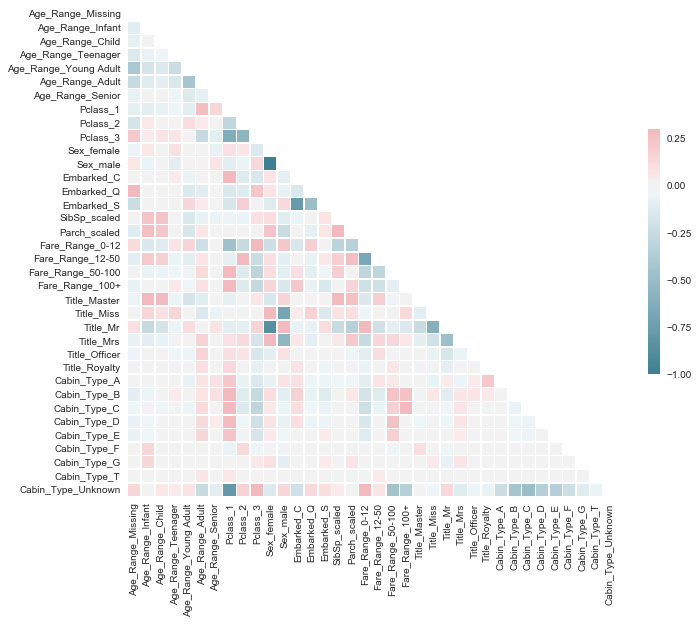

In [13]:
def plot_correlation_heatmap(df):
    corr = df.corr()
    
    sns.set(style='white')
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)


    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={'shrink': .5})
    plt.show()

columns = ['Age_Range_Missing', 'Age_Range_Infant',
           'Age_Range_Child', 'Age_Range_Teenager',
           'Age_Range_Young Adult', 'Age_Range_Adult',
           'Age_Range_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
           'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
           'SibSp_scaled', 'Parch_scaled', 'Fare_Range_0-12',
           'Fare_Range_12-50','Fare_Range_50-100', 'Fare_Range_100+',
           'Title_Master', 'Title_Miss', 'Title_Mr','Title_Mrs', 'Title_Officer',
           'Title_Royalty', 'Cabin_Type_A','Cabin_Type_B', 'Cabin_Type_C', 'Cabin_Type_D',
           'Cabin_Type_E','Cabin_Type_F', 'Cabin_Type_G', 'Cabin_Type_T', 'Cabin_Type_Unknown']

plot_correlation_heatmap(train[columns])

There is a high correlation between *Sex_female*/*Sex_male* and *Title_Miss*/*Title_Mr*/*Title_Mrs*.

Removing the columns *Sex_female* and *Sex_male* since the title data may be stronger.

Also, removing the dummy variables *Pclass_2*, *Age_categories_Teenager*, *Fare_categories_12-50
*, *Title_Master*, *Cabin_type_A* to reduce the collinearity.

In [14]:
columns = ['Age_Range_Missing', 'Age_Range_Infant', 'Age_Range_Child', 
           'Age_Range_Young Adult', 'Age_Range_Adult', 'Age_Range_Senior',
           'Pclass_1', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 
           'SibSp_scaled', 'Parch_scaled', 'Fare_Range_0-12', 'Fare_Range_50-100',
           'Fare_Range_100+', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Officer',
           'Title_Royalty', 'Cabin_Type_B', 'Cabin_Type_C', 'Cabin_Type_D',
           'Cabin_Type_E', 'Cabin_Type_F', 'Cabin_Type_G', 'Cabin_Type_T',
           'Cabin_Type_Unknown']

y = train['Survived']
X = train[columns]

### **Recursive Feature Elimination with Cross Validation**

In [15]:
lr = LogisticRegression()
selector = RFECV(lr, cv=10)
selector.fit(X, y)

RFECV(cv=10,
   estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
   n_jobs=1, scoring=None, step=1, verbose=0)

In [16]:
optimized_columns = X.columns[selector.support_]
print(optimized_columns.values)

['SibSp_scaled' 'Title_Mr' 'Title_Officer' 'Cabin_Type_Unknown']


In [17]:
lr = LogisticRegression()
scores = cross_val_score(lr, X[optimized_columns.values], y, cv=10)
accuracy = np.mean(scores)
print(accuracy)

0.822654919986


accuracy improved! \m/

In [18]:
X = X[optimized_columns.values]

In [19]:
holdout.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'Age_Range', 'Age_Range_Missing',
       'Age_Range_Infant', 'Age_Range_Child', 'Age_Range_Teenager',
       'Age_Range_Young Adult', 'Age_Range_Adult', 'Age_Range_Senior',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Fare_Range', 'Fare_Range_0-12', 'Fare_Range_12-50',
       'Fare_Range_50-100', 'Fare_Range_100+', 'Cabin_Type', 'Title',
       'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Officer',
       'Title_Royalty', 'Cabin_Type_A', 'Cabin_Type_B', 'Cabin_Type_C',
       'Cabin_Type_D', 'Cabin_Type_E', 'Cabin_Type_F', 'Cabin_Type_G',
       'Cabin_Type_T', 'Cabin_Type_Unknown', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'SibSp_scaled', 'Parch_scaled', 'Fare_scaled'],
      dtype='object')

In [20]:
lr = LogisticRegression()
lr.fit(X, y)
holdout_predictions = lr.predict(holdout[optimized_columns.values])

submission_df = {'PassengerId': holdout['PassengerId'], 'Survived': holdout_predictions}
submission = pd.DataFrame(submission_df)
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [21]:
submission.to_csv('submission_v3.csv', index=False)

### Ooooops, before going home, save the precious data...

In [22]:
training_features = [
    'Survived', 'PassengerId', 'Age_Range_Missing', 'Age_Range_Infant', 'Age_Range_Child',
    'Age_Range_Teenager', 'Age_Range_Young Adult', 'Age_Range_Adult', 'Age_Range_Senior',
    'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q',
    'Embarked_S', 'SibSp_scaled', 'Parch_scaled', 'Fare_scaled', 'Fare_Range_0-12',
    'Fare_Range_12-50', 'Fare_Range_50-100', 'Fare_Range_100+', 'Title_Master', 'Title_Miss',
    'Title_Mr', 'Title_Mrs', 'Title_Officer', 'Title_Royalty', 'Cabin_Type_A', 'Cabin_Type_B',
    'Cabin_Type_C', 'Cabin_Type_D', 'Cabin_Type_E', 'Cabin_Type_F', 'Cabin_Type_G',
    'Cabin_Type_T', 'Cabin_Type_Unknown'
    ]

train[training_features].to_csv('train_engineered.csv', index=False)

training_features.remove('Survived')
holdout[training_features].to_csv('holdout_engineered.csv', index=False)